# **Working with Unlabeled Data – Clustering Analysis**

### **Outline**

- Grouping objects by similarity using k-means
    - K-means clustering using scikit-learn
    - A smarter way of placing the initial cluster centroids using k-means++
    - Hard versus soft clustering
    - Using the elbow method to find the optimal number of clusters
    - Quantifying the quality of clustering via silhouette plots

- Organizing clusters as a hierarchical tree
    - Grouping clusters in bottom-up fashion
    - Performing hierarchical clustering on a distance matrix
    - Attaching dendrograms to a heat map
    - Applying agglomerative clustering via scikit-learn

- Locating regions of high density via `DBSCAN`

- The goal of `clustering` is to find a natural grouping in data so that items in the same cluster are more similar to each other than to those from different clusters.

In [1]:
from IPython.display import Image
%matplotlib inline

## **Grouping objects by similarity using k-means**

Clustering (or cluster analysis) is a technique that allows us to find groups of similar objects that are more related to each other than to objects in other groups. Examples of business-oriented applications of clustering include the grouping of documents, music, and movies by different topics, or finding customers that share similar interests based on common purchase behaviors as a basis for recommendation engines.

### **K-means clustering using scikit-learn**

The `k-means` algorithm is extremely easy to implement, but it is also computationally very efficient compared to other clustering algorithms, which might explain its popularity. The k-means algorithm belongs to the category of `prototype-based clustering`.


- `Prototype-based` clustering means that each cluster is represented by a prototype, which is usually either the `centroid (average)` of similar points with continuous features, or the `medoid` (the most representative or the point that minimizes the distance to all other points that belong to a particular cluster) in the case of categorical features. 


- While k-means is very good at identifying clusters with a spherical shape, one of the drawbacks of this clustering algorithm is that we have to specify the number of clusters, `k`, a `priori`. An inappropriate choice for k can result in poor clustering performance.

- Example using a simple two-dimensional dataset for the purpose of visualization

In [2]:
from sklearn.datasets import make_blobs


X, y = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0)

In [4]:
X.shape, y.shape

((150, 2), (150,))

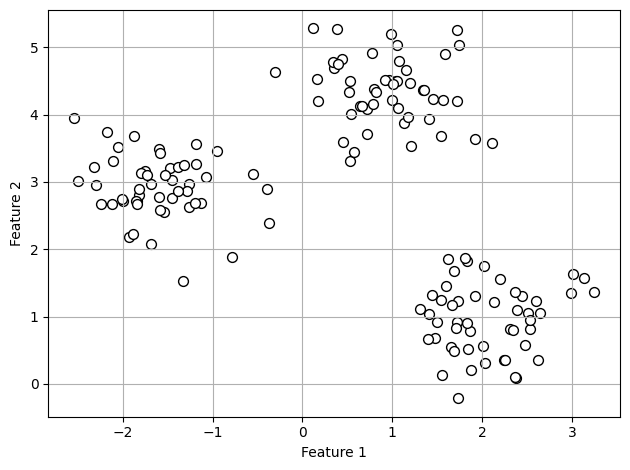

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], 
            c='white', marker='o', edgecolor='black', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.grid()
plt.tight_layout()
#plt.savefig('figures/10_01.png', dpi=300)
plt.show()

- The plot above consists of `150` randomly generated points that are roughly grouped into three regions with higher density, which is visualized via a two-dimensional scatterplot.

In real-world applications of clustering, we do not have any ground-truth category information (information provided as empirical evidence as opposed to inference) about those examples; if we were given class labels, this task would fall into the category of supervised learning. Thus, our goal is to group the examples based on their feature similarities, which can be achieved using the `k-means` algorithm, as summarized by the following four steps:

1. Randomly pick `k` centroids from the examples as initial cluster centers.
   
2. Assign each example to the nearest centroid, $\mu^{(j)}, j \in {1, ..., k}$.

3. Move the centroids to the center of the examples that were assigned to it.

4. Repeat `step 2` and `3` until the cluster assignments do not change or a user-defined tolerance or maximum number of iterations is reached.


**Measuring Similarity — Euclidean Distance and K-Means Optimization**

Similarity between objects is typically measured using **distance metrics**. The most common for continuous features is the **squared Euclidean distance**:

$$d(x, y)^2 = \sum_{j=1}^{m} (x_j - y_j)^2 = \|x - y\|^2$$

where $(x)$ and $(y)$ are points in `(m)`-dimensional space, and `(j)` indexes the features.


#### **K-Means Objective Function**

The **k-means algorithm** minimizes the **within-cluster sum of squared errors (SSE)**, also known as **cluster inertia**:

$$\mathrm{SSE} = \sum_{i=1}^{k} \sum_{x^{(n)} \in C_i} \| x^{(n)} - \mu_i \|^2$$

* $(k)$: number of clusters
* $(x^{(n)})$: data point
* $(\mu_i)$: centroid of cluster (i)
* $(C_i)$: set of points in cluster (i)

**Goal:** Minimize SSE — i.e., assign points to clusters so that each point is as close as possible to its cluster centroid.

**Interpretation:**

* Smaller distances → higher similarity.
* The optimization seeks compact, well-separated clusters.


In [6]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)

- Using the preceding code, we set the number of desired clusters to `3`; having to specify the number of clusters a `priori` is one of the limitations of `k-means`. We set `n_init=10` to run the k-means clustering algorithms 10 times independently, with different random centroids to choose the final model as the one with the lowest SSE. Via the `max_iter` parameter, we specify the maximum number of iterations for each single run (here, 300). Note that the k-means implementation in scikit-learn stops early if it converges before the maximum number of iterations is reached. However, it is possible that k-means does not reach convergence for a particular run, which can be problematic (computationally expensive) if we choose relatively large values for `max_iter`. One way to deal with convergence problems is to choose larger values for `tol`, which is a parameter that controls the tolerance with regard to the changes in the within-cluster SSE to declare convergence. In the preceding code, we chose a tolerance of `1e-04 (=0.0001)`.

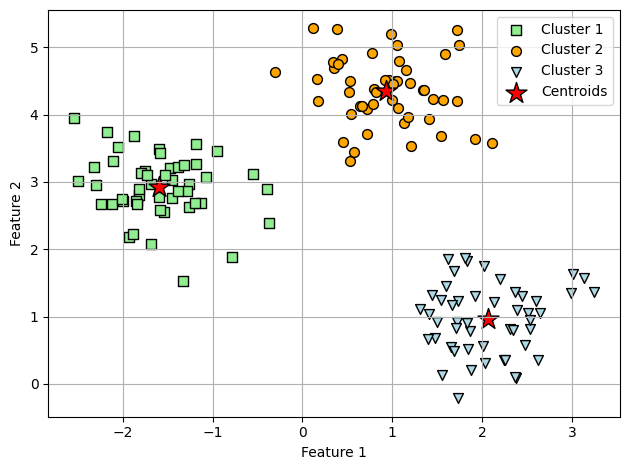

In [ ]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')

plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')

plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster 3')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
#plt.savefig('figures/10_02.png', dpi=300)
plt.show()

- Although `k-means` worked well on this toy dataset, we still have the drawback of having to specify the number of clusters, `k`, `a priori`. The number of clusters to choose may not always be so obvious in real-world applications, especially if we are working with a higher-dimensional dataset that cannot be visualized. The other properties of `k-means` are that clusters do not overlap and are not hierarchical, and we also assume that there is at least one item in each cluster.

#### **A smarter way of placing the initial cluster centroids using k-means++**

**K-Means++ Initialization (Smarter Centroid Placement)**

K-Means++ improves the standard K-Means by choosing better initial centroids to speed up convergence and avoid poor local minima.

**Steps:**

1. Randomly pick the **first centroid** from the data points.
2. For each remaining data point, compute its **distance squared** ($D(x)^2$) from the nearest chosen centroid.
3. Select the **next centroid** with a probability proportional to $D(x)^2$ — points farther from existing centroids are more likely to be chosen.
4. Repeat step 3 until **k centroids** are initialized.
5. Proceed with the standard **K-Means algorithm**.

**Key Benefit:**
Reduces initialization bias, improves clustering accuracy, and typically requires fewer iterations for convergence.


### **Hard vs. Soft Clustering**


#### **1. Hard Clustering**

**Concept:**
Each data point belongs to exactly one cluster. There is no uncertainty — cluster assignment is *crisp*.

**Mathematical Representation:**
Given a dataset $`X = \{x_1, x_2, \dots, x_n\}`$ and $`k`$ clusters, hard clustering defines an assignment function:

$`r_{ij} =
\begin{cases}
1, & \text{if data point } x_i \text{ belongs to cluster } j \\
0, & \text{otherwise}
\end{cases}`$

Each sample satisfies:

$$\sum_{j=1}^{k} r_{ij} = 1$$

**Objective Function (K-Means):**

$$J = \sum_{i=1}^{n} \sum_{j=1}^{k} r_{ij} \| x_i - \mu_j \|^2$$

where $`\mu_j`$ is the centroid of cluster $`j`$.


**Optimization Steps:**

1. **Assignment step:**
   Assign each point to the closest centroid:
   $`r_{ij} = 1 \text{ if } j = \arg\min_l \|x_i - \mu_l\|^2`$
2. **Update step:**
   Recompute centroid:
   $`\mu_j = \frac{\sum_{i=1}^{n} r_{ij} x_i}{\sum_{i=1}^{n} r_{ij}}`$

This iterative process minimizes intra-cluster variance (compact clusters).



#### **2. Soft Clustering**

**Concept:**
Each data point can belong to multiple clusters with certain probabilities (or degrees of membership).

**Mathematical Representation:**
$`r_{ij} \in [0, 1]`$ represents the **probability** or **membership weight** that $`x_i`$ belongs to cluster $`j`$, satisfying:

$$\sum_{j=1}^{k} r_{ij} = 1$$

**Example: Gaussian Mixture Models (GMM)**

A GMM assumes data is generated from a mixture of $`k`$ Gaussian distributions:

$$p(x_i) = \sum_{j=1}^{k} \pi_j \, \mathcal{N}(x_i \,|\, \mu_j, \Sigma_j)$$

where:

* $`\pi_j`$ = mixing coefficient (cluster prior), $`\sum_j \pi_j = 1`$
* $`\mathcal{N}(x_i | \mu_j, \Sigma_j)`$ = Gaussian distribution with mean $`\mu_j`$ and covariance $`\Sigma_j`$

**E-step (Expectation):**
Compute soft membership probabilities:

$$r_{ij} = \frac{\pi_j \, \mathcal{N}(x_i | \mu_j, \Sigma_j)}{\sum_{l=1}^{k} \pi_l \, \mathcal{N}(x_i | \mu_l, \Sigma_l)}$$

**M-step (Maximization):**
Update parameters:

$$\mu_j = \frac{\sum_i r_{ij} x_i}{\sum_i r_{ij}}, \quad
\Sigma_j = \frac{\sum_i r_{ij} (x_i - \mu_j)(x_i - \mu_j)^\mathrm{T}}{\sum_i r_{ij}}, \quad
\pi_j = \frac{1}{n} \sum_i r_{ij}$$



#### **3. Comparison Summary**

| Feature          | Hard Clustering                  | Soft Clustering            |
| ---------------- | -------------------------------- | -------------------------- |
| Membership       | Binary (0 or 1)                  | Probabilistic (0–1)        |
| Example          | K-Means                          | GMM                        |
| Objective        | Minimize within-cluster variance | Maximize data likelihood   |
| Model assumption | Spherical clusters               | Elliptical clusters        |
| Flexibility      | Rigid                            | Flexible and probabilistic |
| Output           | Cluster labels                   | Membership probabilities   |



#### **Key Insight:**

Hard clustering is a **special case** of soft clustering where $`r_{ij} ∈ \{0, 1\}`$ instead of $`[0, 1]`$.
Soft clustering generalizes hard clustering by accounting for uncertainty and overlapping cluster boundaries.


### **Using the elbow method to find the optimal number of clusters**

#### **Concept**

The **Elbow Method** helps determine the ideal number of clusters (*k*) in a clustering problem (commonly K-Means) by analyzing how the **within-cluster sum of squared errors (SSE)** changes as *k* increases.

As *k* grows:

* SSE (or inertia) **decreases** because clusters fit the data more closely.
* However, beyond a certain point, the improvement becomes **marginal** — forming an “elbow” in the curve.

That **elbow point** represents the optimal *k* — balancing compactness and simplicity.



#### **Mathematical Definition**

For each *k*, compute the total **within-cluster sum of squared errors**:

$$\mathrm{SSE}(k) = \sum_{j=1}^{k} \sum_{x_i \in C_j} \|x_i - \mu_j\|^2$$

where:

* $`C_j`$ = set of points in cluster $`j`$
* $`\mu_j`$ = centroid of cluster $`j`$



#### **Procedure**

1. Run K-Means (or another clustering algorithm) for a range of $`k`$ values (e.g., 1–10).
2. Compute $`\mathrm{SSE}(k)`$ for each $`k`$.
3. Plot $`\mathrm{SSE}(k)`$ vs. $`k`$.
4. Identify the **“elbow point”** — the value of $`k`$ where the rate of decrease sharply slows down.



#### **Intuition**

* **Before the elbow:** Adding clusters greatly reduces SSE (significant improvement).
* **After the elbow:** Adding clusters yields little reduction (overfitting).



#### **Summary Table**

| Step | Description                            |
| ---- | -------------------------------------- |
| 1    | Compute K-Means for several *k* values |
| 2    | Record the SSE (inertia) for each      |
| 3    | Plot *k* vs. SSE                       |
| 4    | Find the "elbow" — optimal *k*         |



**Insight:**
The Elbow Method is heuristic — it provides a *visual cue*, not a strict rule.
For complex or high-dimensional data, methods like the **Silhouette Score** or **Gap Statistic** can be used to confirm the result.


- We don't need to compute the within-cluster `SSE` explicitly when we are using `scikit-learn`, as it is already accessible via the `inertia_` attribute after fitting a `KMeans` model:

In [8]:
print(f'Distortion: {km.inertia_:.2f}')

Distortion: 72.48


- Based on the within-cluster `SSE`, we can use a graphical tool, the so-called `elbow method`, to estimate the optimal number of clusters, `k`, for a given task. We can say that if `k` increases, the distortion will decrease. 

- This is because the examples will be closer to the centroids they are assigned to. The idea behind the elbow method is to identify the value of `k` where the distortion begins to increase most rapidly, which will become clearer if we plot the distortion for different values of `k`:

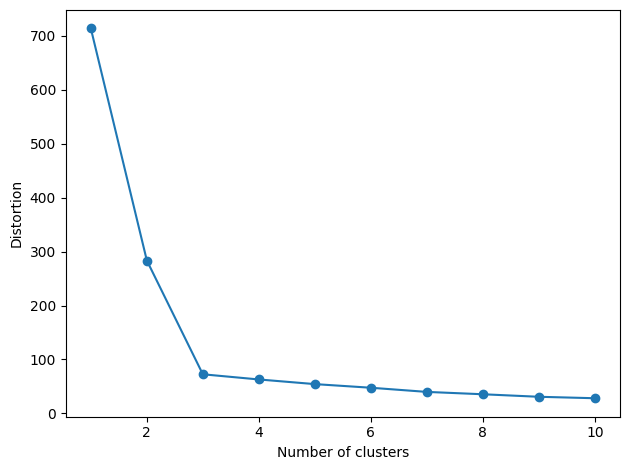

In [10]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

- As seen from the figure above, the `elbow` is located as `k = 3`, so this is supporting evidence that `k = 3` is indeed a good choice for this dataset.

### **Quantifying the quality of clustering via silhouette plots**

#### **1. Concept Overview**

The **Silhouette Coefficient** measures how well each data point fits within its assigned cluster compared to other clusters. It combines two ideas:

* **Cohesion** — how close a point is to others in its cluster.
* **Separation** — how far it is from points in neighboring clusters.

The result is a score between **−1** and **1**:

* **+1** → well-clustered (far from other clusters).
* **0** → on the border between two clusters.
* **−1** → likely misclassified (closer to another cluster).

Silhouette **plots** visualize these scores for all samples, providing insight into cluster structure and validity.


#### **2. Mathematical Formulation**

For each data point $`x_i`$:

1. **Intra-cluster distance (Cohesion)**
   Average distance between $`x_i`$ and all other points in its cluster:

   $`a(i) = \frac{1}{|C_i| - 1} \sum_{x_j \in C_i, j \ne i} \|x_i - x_j\|`$

   where $`C_i`$ is the cluster containing $`x_i`$.

2. **Nearest-cluster distance (Separation)**
   Minimum average distance between $`x_i`$ and all points in other clusters:

   $`b(i) = \min_{k \ne i} \frac{1}{|C_k|} \sum_{x_j \in C_k} \|x_i - x_j\|`$

3. **Silhouette Coefficient for a single point**

   $`s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}`$

   * $`s(i) \approx 1`$ → $`x_i`$ is well-matched to its own cluster.
   * $`s(i) \approx 0`$ → $`x_i`$ lies near a cluster boundary.
   * $`s(i) < 0`$ → $`x_i`$ is likely in the wrong cluster.



#### **3. Overall Silhouette Score**

The overall clustering quality is the **mean** silhouette coefficient across all points:

$$S = \frac{1}{n} \sum_{i=1}^{n} s(i)$$

where $`S`$ represents the **average silhouette score** for the dataset.



#### **4. Silhouette Plot Interpretation**

A **silhouette plot** shows each point’s $`s(i)`$ value grouped by cluster.

* Each cluster’s silhouette width represents its **cohesiveness**.
* The **average silhouette line** indicates overall clustering quality.
* Well-separated clusters show **tall, narrow bars** near +1.
* Poorly separated clusters show **wide, overlapping bars** near 0 or below.



#### **5. Guidelines**

| Metric             | Interpretation                                          |
| ------------------ | ------------------------------------------------------- |
| $`S > 0.7`$        | Excellent clustering (strong structure).                |
| $`0.5 < S ≤ 0.7`$  | Reasonable structure, could be improved.                |
| $`0.25 < S ≤ 0.5`$ | Weak structure, possible overlap.                       |
| $`S ≤ 0.25`$       | No substantial structure (clusters may be meaningless). |



#### **6. Advantages**

* **Model-independent:** Works with any clustering algorithm.
* **Quantitative & Visual:** Offers both a numerical score and an interpretable plot.
* **Diagnostic:** Identifies misclassified samples and overlapping clusters.



#### **7. Summary Formula Block**

$$\begin{align*}
a(i) &= \text{mean intra-cluster distance for } x_i \\
b(i) &= \text{mean nearest-cluster distance for } x_i \\
s(i) &= \frac{b(i) - a(i)}{\max(a(i), b(i))} \\
S &= \frac{1}{n} \sum_{i=1}^{n} s(i)
\end{align*}$$


**In essence:**
Silhouette plots transform abstract cluster assignments into interpretable measures of **compactness** and **separation**, making them one of the most reliable tools for evaluating unsupervised learning results.


- The silhouette coefficient is available as `silhouette_samples` from scikit-learn's metric module, and optionally, the `silhouette_scores` function can be imported for convenience. 

- The `silhouette_scores` function calculates the average silhouette coefficient across all examples, which is equivalent to `numpy.mean(silhouette_samples(...))`. 

- A plot of the silhouette coefficients for a k-means clustering with `k = 3`.

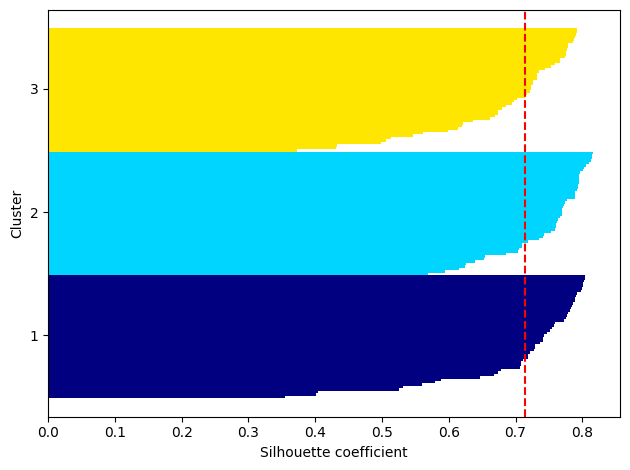

In [ ]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0

yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('figures/10_04.png', dpi=300)
plt.show()

- As you can see in the preceding `silhouette plot`, the silhouette coefficients are not close to `0` and are approximately equally far away from the average silhouette score, which is, in this case, an indicator of good `clustering`. 

- The average silhouette coefficient of the plot (dotted line).

- A silhouette plot for a relatively `bad` clustering.
- K-means algorithm with only two `2` centroids.

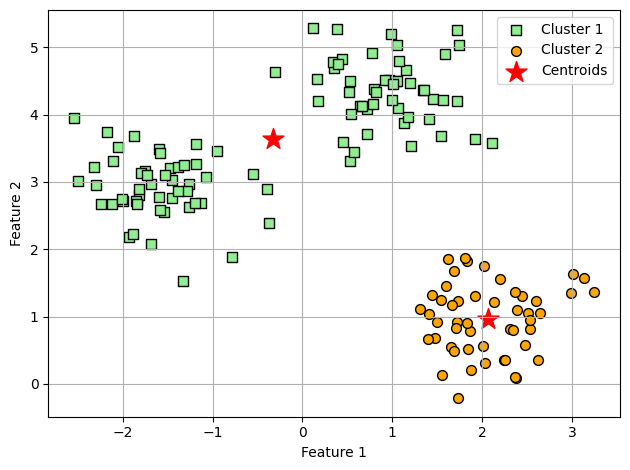

In [12]:
km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            edgecolor='black',
            marker='s',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            edgecolor='black',
            marker='o',
            label='Cluster 2')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='Centroids')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('figures/10_05.png', dpi=300)
plt.show()

- create the silhouette plot to evaluate the results:

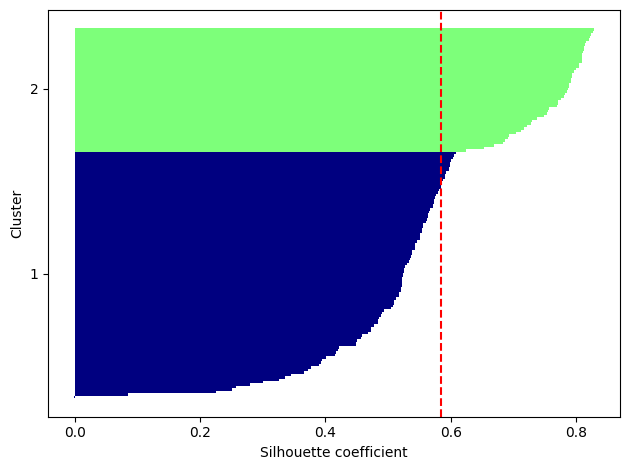

In [13]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0

yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('figures/10_06.png', dpi=300)
plt.show()

---

## **Organizing clusters as a hierarchical tree**


#### **1. Concept Overview**

Hierarchical clustering organizes data into a **tree-like structure** called a **dendrogram**, representing nested clusters formed by successive merging (agglomerative) or splitting (divisive) steps.

Unlike *k-means*, hierarchical clustering doesn’t require pre-specifying the number of clusters — instead, clusters are revealed by “cutting” the dendrogram at different levels.



### **2. Two Main Approaches**

| Type                          | Description                                                                                   | Process                  |
| ----------------------------- | --------------------------------------------------------------------------------------------- | ------------------------ |
| **Agglomerative (Bottom-up)** | Starts with each data point as its own cluster, then successively merges the closest pairs.   | Most common in practice. |
| **Divisive (Top-down)**       | Starts with all data points in one cluster, then recursively splits it into smaller clusters. | Computationally heavier. |



#### **3. Mathematical Formulation**

Let $`X = \{x_1, x_2, \dots, x_n\}`$ be a dataset in $`\mathbb{R}^m`$.
We define a **distance metric** between data points, e.g., Euclidean:

$$d(x_i, x_j) = \| x_i - x_j \|_2$$

##### **Step 1 — Initialization**

Each data point starts as its own cluster:

$$C = \{ \{x_1\}, \{x_2\}, \dots, \{x_n\} \}$$

##### **Step 2 — Compute Inter-Cluster Distances**

At each iteration, the algorithm merges two clusters $`A`$ and $`B`$ that have the **minimum linkage distance**, defined by a linkage criterion.



#### **4. Linkage Criteria (Distance Between Clusters)**

| Method               | Formula                                              | Description                                                             |   |   |                                                   |                                                         |   |   |                         |                                                                                    |
| -------------------- | ---------------------------------------------------- | ----------------------------------------------------------------------- | - | - | ------------------------------------------------- | ------------------------------------------------------- | - | - | ----------------------- | ---------------------------------------------------------------------------------- |
| **Single linkage**   | $`D(A,B) = \min_{x_i \in A, x_j \in B} d(x_i, x_j)`$ | Distance between the closest points (tends to form elongated clusters). |   |   |                                                   |                                                         |   |   |                         |                                                                                    |
| **Complete linkage** | $`D(A,B) = \max_{x_i \in A, x_j \in B} d(x_i, x_j)`$ | Distance between the farthest points (tends to form compact clusters).  |   |   |                                                   |                                                         |   |   |                         |                                                                                    |
| **Average linkage**  | $`D(A,B) = \frac{1}{                                 \| A                                                                       \|   \| B \| } \sum_{x_i \in A} \sum_{x_j \in B} d(x_i, x_j)`$ | Average distance between all pairs (balanced approach). |   |   |                         |                                                                                    |
| **Ward’s method**    | $`\Delta(A,B) = \frac{                               \| A                                                                       \|   \| B \| }{                                                \| A                                                       \| + \| B \| } \| \mu_A - \mu_B \|^2`$ | Minimizes the increase in total within-cluster variance after merging (most used). |



#### **5. Step 3 — Update and Repeat**

After merging clusters $`A`$ and $`B`$, replace them with a new cluster $`C_{AB}`$ and recompute distances between $`C_{AB}`$ and all remaining clusters using the chosen linkage.

Repeat until all data points belong to one cluster.



#### **6. Step 4 — Dendrogram Construction**

A **dendrogram** is a binary tree that visually represents the sequence of merges:

* The **height** of each node corresponds to the **distance (linkage)** at which clusters were merged.
* Cutting the tree at a specific height $`h`$ gives the desired number of clusters.

Mathematically, the clustering can be represented by a hierarchy $`T = \{(A,B,\Delta(A,B))\}`$, where each tuple records a merge and its linkage distance.



#### **7. Mathematical Insight — Ward’s Criterion**

Ward’s linkage minimizes the **total within-cluster variance** (SSE):

$$\mathrm{SSE} = \sum_{j=1}^{k} \sum_{x_i \in C_j} \|x_i - \mu_j\|^2$$

When two clusters $`A`$ and $`B`$ are merged, the increase in SSE is:

$$\Delta(A,B) = \frac{|A||B|}{|A| + |B|} \| \mu_A - \mu_B \|^2$$

This approach ensures more **compact and spherical** clusters.



#### **8. Advantages**

* **No need for k upfront** — the dendrogram reveals possible numbers of clusters.
* **Interpretable** — provides multi-level insight into data structure.
* **Deterministic** — unlike k-means, results are reproducible.



#### **9. Limitations**

* **Computational complexity:** $`O(n^3)`$ for naive implementations.
* **Sensitivity:** Affected by outliers and chosen distance metrics.
* **No cluster reassignment:** Once merged, cannot be undone.



#### **10. Summary Equations**

$$\begin{align*}
d(x_i, x_j) &= \|x_i - x_j\|_2 \\
D_{\mathrm{single}}(A,B) &= \min_{x_i \in A, x_j \in B} d(x_i, x_j) \\
D_{\mathrm{complete}}(A,B) &= \max_{x_i \in A, x_j \in B} d(x_i, x_j) \\
D_{\mathrm{average}}(A,B) &= \frac{1}{|A||B|} \sum_{x_i \in A} \sum_{x_j \in B} d(x_i, x_j) \\
\Delta_{\mathrm{Ward}}(A,B) &= \frac{|A||B|}{|A| + |B|} \| \mu_A - \mu_B \|^2
\end{align*}$$



**In essence:**

Hierarchical clustering builds a *hierarchy of nested partitions*, from fine to coarse granularity, by repeatedly merging or splitting clusters based on distance or variance criteria. The dendrogram captures this entire process, enabling both **visual interpretation** and **data-driven selection** of cluster numbers.



### **Grouping clusters in a bottom-up fashion**

- The two standard algorithms for agglomerative hierarchical clustering are `single linkage` and `complete linkage`. Using single linkage, we compute the distances between the most similar members for each pair of clusters and merge the two clusters for which the distance between the most similar members is the smallest. 

- The complete linkage approach is similar to single linkage but, instead of comparing the most similar members in each pair of clusters, we compare the most dissimilar members to perform the merge.


![Linkage Approach](./figures/linkage-approach.png)

`Agglomerative clustering` using the complete linkage approach. Hierarchical complete linkage clustering is an iterative procedure that can be summarized by the following steps:

- Compute a pair-wise distance matrix of all examples.
- Represent each data point as a singleton cluster.
- Merge the two closest clusters based on the distance between the most dissimilar (distant) members.
- Update the cluster linkage matrix.
- Repeat steps 2-4 until one single cluster remains.


In [ ]:
import pandas as pd
import numpy as np

np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample([5, 3])*10

df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


### **Performing hierarchical clustering on a distance matrix**

- Distance matrix as input for the hierarchical clustering algorithm.

In [17]:
from scipy.spatial.distance import pdist, squareform
row_dist = pd.DataFrame(squareform(
                        pdist(df, metric='euclidean')),
                        columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [18]:
from scipy.cluster.hierarchy import linkage
help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.
    
    The input y may be either a 1-D condensed distance matrix
    or a 2-D array of observation vectors.
    
    If y is a 1-D condensed distance matrix,
    then y must be a :math:`\binom{n}{2}` sized
    vector, where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents t

We can either pass a condensed distance matrix (upper triangular) from the ``pdist` function, or we can pass the "original" data array and define the `metric='euclidean'` argument in `linkage`. However, we should not pass the squareform distance matrix, which would yield different distance values although the overall clustering could be the same.

- **Incorrect approach**

In [24]:
# 1. incorrect approach: Squareform distance matrix

from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=[f'cluster {(i + 1)}'
                    for i in range(row_clusters.shape[0])])

/var/folders/9z/v7273dts7dd75tz0ppy1qfdr0000gn/T/ipykernel_41623/250766135.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_clusters = linkage(row_dist, method='complete', metric='euclidean')


,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


- **Correct approach**

In [25]:
# 2. correct approach: Condensed distance matrix

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
            index=[f'cluster {(i + 1)}'
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


- **Correct approach**

In [26]:
# 3. correct approach: Input matrix

row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=[f'cluster {(i + 1)}'
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


- To take a closer look at the clustering results, we can turn those results into a pandas DataFrame (best viewed in a Jupyter notebook) as follows:

In [23]:
pd.DataFrame(row_clusters,
             columns=['row label 1',
                      'row label 2',
                      'distance',
                      'no. of items in clust.'],
             index=[f'cluster {(i + 1)}' for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


- Visualize the results in the form of a dendrogram:

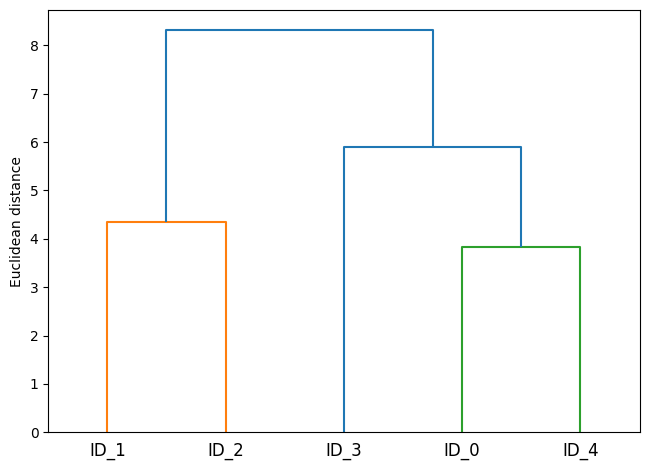

In [ ]:
from scipy.cluster.hierarchy import dendrogram

# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters, 
                       labels=labels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
#plt.savefig('figures/10_11.png', dpi=300, 
#            bbox_inches='tight')
plt.show()

- Such a dendrogram summarizes the different clusters that were formed during the agglomerative hierarchical clustering; for example, you can see that the examples `ID_0` and `ID_4`, followed by `ID_1` and `ID_2`, are the most similar ones based on the Euclidean distance metric.

### **Attaching dendrograms to a heat map**

In practical applications, hierarchical clustering dendograms are often used in combination with `heat map`, which allows us to represent the individual values in the data array or matrix containing our training examples with a color code.

1. We create a new figure object and define the x axis position, y axis position, width, and height of the dendrogram via the add_axes attribute. Furthermore, we rotate the dendrogram 90 degrees counterclockwise. The code is as follows:

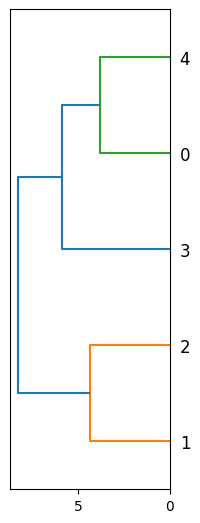

In [30]:
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.99, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters,
                       orientation='left')

2. Next, we reorder the data in our initial `DataFrame` according to the clustering labels that can be accessed from the dendrogram object, which is essentially a Python dictionary, via the leaves key. The code is as follows:

In [32]:
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]
df_rowclust

,X,Y,Z
ID_4,4.385722,0.596779,3.980443
ID_0,6.964692,2.861393,2.268515
ID_3,3.921175,3.431780,7.290497
ID_2,9.807642,6.848297,4.809319
ID_1,5.513148,7.194690,4.231065


3. Now, we construct the heat map from the reordered DataFrame and position it next to the dendrogram:

In [35]:
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])
cax = axm.matshow(df_rowclust,
                  interpolation='nearest',
                  cmap='hot_r')

4. Finally, we modify the aesthetics of the dendrogram by removing the axis ticks and hiding the axis spines. Also, we add a color bar and assign the feature and data record names to the `x` and `y` axis tick labels, respectively:

In [ ]:
axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)

fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))
plt.show()

/var/folders/9z/v7273dts7dd75tz0ppy1qfdr0000gn/T/ipykernel_41623/2970416162.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axm.set_xticklabels([''] + list(df_rowclust.columns))
/var/folders/9z/v7273dts7dd75tz0ppy1qfdr0000gn/T/ipykernel_41623/2970416162.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axm.set_yticklabels([''] + list(df_rowclust.index))


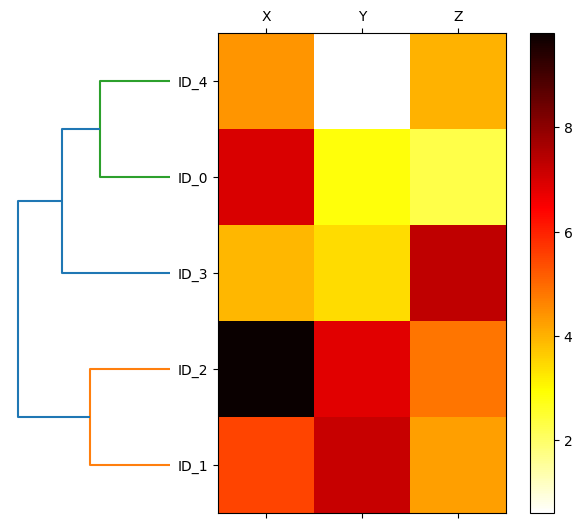

In [38]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
    i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)

axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

#plt.savefig('figures/10_12.png', dpi=300)
plt.show()


### **Applying agglomerative clustering via scikit-learn**

`AgglomerativeClustering` implementation in scikit-learn, which allows us to choose the number of clusters that we want to return. This is useful if we want to prune the hierarchical cluster tree. 

- By setting the `n_cluster` parameter to 3, we will now cluster the input examples into three groups using the same complete linkage approach based on the Euclidean distance metric as before:

In [40]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3,
                             metric='euclidean',
                             linkage='complete')

labels = ac.fit_predict(X)
print(f'Cluster labels: {labels}')

Cluster labels: [1 0 0 2 1]


- Looking at the predicted cluster labels, we can see that the first and the fifth examples `(ID_0 and ID_4)` were assigned to one cluster (label 1), and the examples `ID_1` and `ID_2` were assigned to a second cluster (label 0). The example `ID_3` was put into its own cluster (label 2). Overall, the results are consistent with the results that we observed in the dendrogram. We should note, though, that `ID_3` is
more similar to `ID_4` and `ID_0` than to `ID_1` and `ID_2`, as shown in the preceding dendrogram figure; this is not clear from scikit-learn’s clustering results. 

In [41]:
ac = AgglomerativeClustering(n_clusters=2,
                             metric='euclidean',
                             linkage='complete')
labels = ac.fit_predict(X)
print(f'Cluster labels: {labels}')

Cluster labels: [0 1 1 0 0]


## **Locating regions of high density via DBSCAN**

Although we can’t cover the vast number of different clustering algorithms, let’s at least include one more approach to clustering: `density-based spatial clustering of applications with noise (DBSCAN)`, which does not make assumptions about spherical clusters like `k-means`, nor does it partition the dataset into hierarchies that require a manual cut-off point. As its name implies, `density-based clustering` assigns cluster labels based on dense regions of points. In `DBSCAN`, the notion of density is defined as the number of points within a specified radius, $\epsilon$


According to the `DBSCAN` algorithm, a special label is assigned to each example (data point) using the following criteria:

- A point is considered a `core point` if at least a specified number (MinPts) of neighboring points fall within the specified radius, $\epsilon$.

- A `border point` is a point that has fewer neighbors than MinPts within $\epsilon$, but lies within the $\epsilon$ radius of a core point.

- All other points that are neither core nor border points are considered `noise points`.

After labeling the points as core, border, or noise, the `DBSCAN` algorithm can be summarized in two simple steps:

- From a separate cluster for each core point or connected group of core points. (Core points are connected if they are no farther away from $\epsilon$.)

- Assign each border point to the cluster of its corresponding core point.

Summary of core points, border points, and noise points;

![Core, noise, and border points of DBSCAN](./figures/core-noise-border.png)

- A new dataset of half-moon-shaped structures to compare `k-means` clustering, hierarchical clustering, and `DBSCAN`:

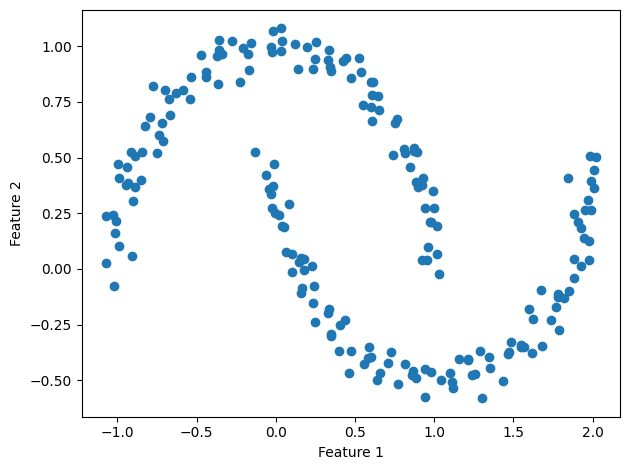

In [42]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200,
                  noise=0.05,
                  random_state=0)

plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

- **K-means and hierarchical clustering:**

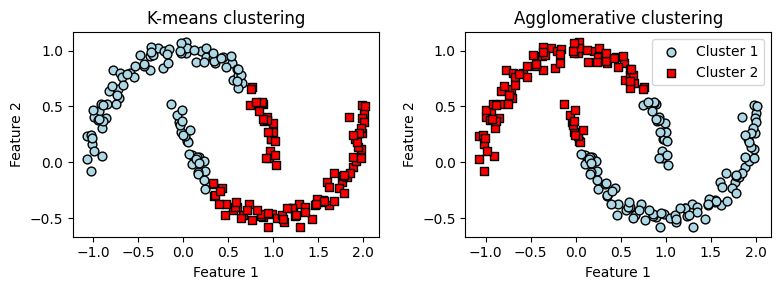

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2,
            random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            c='lightblue',
            edgecolor='black',
            marker='o',
            s=40,
            label='cluster 1')
ax1.scatter(X[y_km == 1, 0], 
            X[y_km == 1, 1],
            edgecolor='black',
            c='red', 
            marker='s', 
            s=40, 
            label='cluster 2')

ax1.set_title('K-means clustering')

ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')


ac = AgglomerativeClustering(n_clusters=2,
                             metric='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], 
            X[y_ac == 0, 1], 
            c='lightblue',
            edgecolor='black',
            marker='o', 
            s=40, 
            label='Cluster 1')
ax2.scatter(X[y_ac == 1, 0], 
            X[y_ac == 1, 1], 
            c='red',
            edgecolor='black',
            marker='s', 
            s=40, 
            label='Cluster 2')
ax2.set_title('Agglomerative clustering')

ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

plt.legend()
plt.tight_layout()
#plt.savefig('figures/10_15.png', dpi=300)
plt.show()

- **Density-based clustering:**

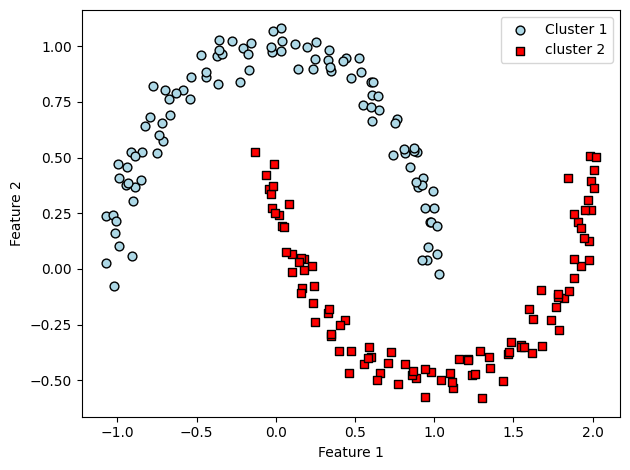

In [64]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2,
            min_samples=5,
            metric='euclidean')

y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0],
            X[y_db == 0, 1],
            c='lightblue',
            edgecolor='black',
            marker='o',
            s=40,
            label='Cluster 1')

plt.scatter(X[y_db == 1, 0],
            X[y_db == 1, 1],
            c='red',
            edgecolor='black',
            marker='s',
            s=40,
            label='cluster 2')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
X.shape, y_db.shape

((200, 2), (200,))

- The `DBSCAN` algorithm can successfully detect the half-moon shapes, which highlights one of the strengths of `DBSCAN`- clustering data of arbitrary shapes.

- However, we should also note some of the disadvantages of DBSCAN. With an increasing number of features in our dataset—assuming a fixed number of training examples—the negative effect of the curse of dimensionality increases.

- This is especially a problem if we are using the Euclidean distance metric. However, the problem of the curse of dimensionality is not unique to DBSCAN: it also affects other clustering algorithms that use the Euclidean distance metric, for example, k-means and hierarchical clustering algorithms.